In [28]:
import re
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(2000)

In [29]:
model_path = '../tflite_models/float32/yolox-tiny.tflite'
img_path = '../COCO/val2017/000000175251.jpg'

In [30]:
LABEL_PATH = 'coco_labels_actual.txt'
labels = dict()
with open(LABEL_PATH, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for row_number, content in enumerate(lines):
            pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
            if len(pair) == 2 and pair[0].strip().isdigit():
                labels[int(pair[0])] = pair[1].strip()
            else:
                labels[row_number+1] = pair[0].strip()
print(labels)
colors = np.random.randint(0, 255, size=(len(labels), 3),dtype="int32")

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic-light', 11: 'fire-hydrant', 12: 'street-sign', 13: 'stop-sign', 14: 'parking-meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 26: 'hat', 27: 'backpack', 28: 'umbrella', 29: 'shoe', 30: 'eye-glasses', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports-ball', 38: 'kite', 39: 'baseball-bat', 40: 'baseball-glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis-racket', 44: 'bottle', 45: 'plate', 46: 'wine-glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot-dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted-plant', 65: 'bed', 66: 'mirror', 67: 'dining-table', 68: 'window', 69: 'de

In [31]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
img_shape = tuple(input_shape[1:3])
input_type = input_details[0]['dtype']
print(img_shape, input_type)

(416, 416) <class 'numpy.float32'>


In [32]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_img = img
scaled_img = cv2.resize(img, img_shape)
scaled_img = np.expand_dims(scaled_img, axis=0)
if input_type == np.float32:
    scaled_img = scaled_img.astype(np.float32)
elif input_type == np.uint8:
    scaled_img = scaled_img.astype(np.uint8)

In [33]:
interpreter.set_tensor(input_details[0]['index'], scaled_img)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [34]:
print("IN: ", scaled_img.shape)
print("OUT: ", output_data.shape)
bboxes = output_data[:, 0:4]
scores = output_data[:, 4]
class_ids = output_data[:, 5]

IN:  (1, 416, 416, 3)
OUT:  (17, 6)


In [35]:
nms_idxs = tf.image.non_max_suppression(
    bboxes,
    scores,
    max_output_size=100,
    iou_threshold=0.4,
    score_threshold=0.3
    )
bboxes = bboxes[nms_idxs]
class_ids = class_ids[nms_idxs]
scores = scores[nms_idxs]


missing_labels = [12, 26, 29, 30, 45, 66, 68, 69, 71, 83, 91]

for i in range(len(class_ids)):
    for label in missing_labels:
        if class_ids[i] > label:
            class_ids[i] = class_ids[i] + 1

class_ids += 1

print(class_ids)
# ranges = [(1, 12), (12, 26), (26, 29), (29, 30), (30, 45), (45, 66), (66, 68), (68, 69), (69, 71), (71, 83), (83, 91)]
# label_map = list()
# for i, part in enumerate(ranges):
#     for num in range(part[0], part[1]):
#         label_map.append(i+1)

# print(len(label_map))

# class_ids = [class_id + label_map[int(class_id)] for class_id in class_ids]
# print(class_ids)

TypeError: 'int' object is not iterable

[ 28 7 612 604 ] 0.91, 1.0 person
[ 292 346 548 415 ] 0.50, 90.0 toothbrush


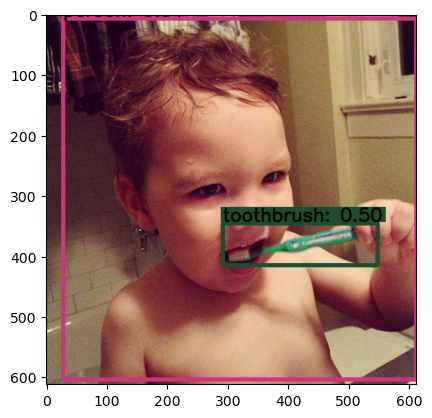

In [ ]:
for bbox, score, class_id in zip(bboxes, scores, class_ids):
   
    label = labels[int(class_id)]
    color = tuple([int(c) for c in colors[int(class_id)]])

    x_min, y_min, x_max, y_max = bbox
    x_min_ratio = x_min / input_shape[1]
    y_min_ratio = y_min / input_shape[2]
    x_max_ratio = x_max / input_shape[1]
    y_max_ratio = y_max / input_shape[2]

    x_min = int(x_min_ratio * original_img.shape[1])
    y_min = int(y_min_ratio * original_img.shape[0])
    x_max = int(x_max_ratio * original_img.shape[1])
    y_max = int(y_max_ratio * original_img.shape[0])

    print('[',x_min, y_min, x_max, y_max,']', f'{score:.2f}, {class_id}', label)
    cv2.rectangle(original_img, (x_min, y_min), (x_max, y_max), color, 6)

    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    detection_info = f'{label}: {score:.2f}'
    label_size = cv2.getTextSize(detection_info, font_face, font_scale, font_thickness)[0]
    label_x_min, label_y_min = x_min - 3, y_min - 3
    label_x_max, label_y_max = x_min + 3 + label_size[0], y_min - 5 - label_size[1]
    cv2.rectangle(original_img, (label_x_min, label_y_min), (label_x_max, label_y_max), color, -1)
    cv2.putText(original_img, detection_info, (x_min, y_min - 4), font_face, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)

plt.imshow(original_img)
